# Modelling acceleration: piecewise random impulses acceleration (PRIA) model

The goal is to "hope for" the central limit theorem to kick in, perhaps making integration of piecewise random acceleration will converge (at least in the first and second moment) to those of the Wiener processes.

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt 

from scipy.stats import norm, gamma

%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's create a bunch of random acceleration impulses, we will see if they create the same covariance kernel that we witnessed (third-degree polynomial). The following assumptions were made:

1. The duration of acceleration follows gamma distribution with loc = alpha = shape = 10, scale = 1
2. The value of the acceleration follows a normal distribution with mean = loc = 0, scale = sd = 0.1

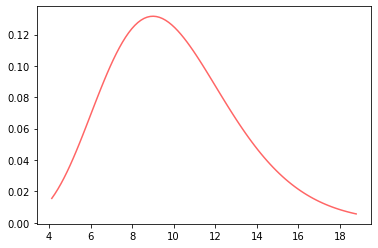

In [29]:
a = 10
x = np.linspace(gamma.ppf(0.01, a, scale=1),
                gamma.ppf(0.99, a, scale=1), 100)
plt.plot(x, gamma.pdf(x, a, scale=1),
       'r-', alpha=0.6, label='gamma pdf')

In [30]:
def sampl():
    duration = gamma.rvs(a = 10, scale = 1)
    idle = gamma.rvs(a = 40, scale = 1)
    accel = norm.rvs(loc = 0, scale = 0.01)
    return (duration, accel, idle)

In [31]:
def sample_traj(length = 500):
    t = 0
    x = np.zeros((length,))
    while t < length: 
        duration, accel, idle = sampl()
        duration = int(np.round(duration))
        idle = int(np.round(idle))
        if t+duration < length:
            x[t:t+duration] = accel
        else:
            x[t:length] = accel
        t = t+duration+idle
    return x

In [32]:
from scipy import integrate

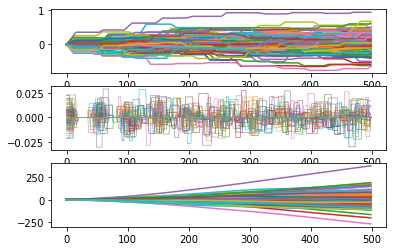

In [33]:
trajs_to_plot = 100
traj_length = 500

y_trajs = np.zeros((trajs_to_plot, traj_length))
for i in range(trajs_to_plot):
    accel_traj = sample_traj(length = traj_length)
    vel_traj = integrate.cumulative_trapezoid(accel_traj, np.arange(accel_traj.shape[0]), initial=0)
    x_traj = integrate.cumulative_trapezoid(vel_traj, np.arange(accel_traj.shape[0]), initial=0)
    ax1 = plt.subplot(3,1,1)
    ax1.plot(vel_traj)
    ax2 = plt.subplot(3,1,2)
    ax2.plot(accel_traj, linewidth=0.5)
    ax3 = plt.subplot(3,1,3)
    ax3.plot(x_traj)
    y_trajs[i,:] = x_traj

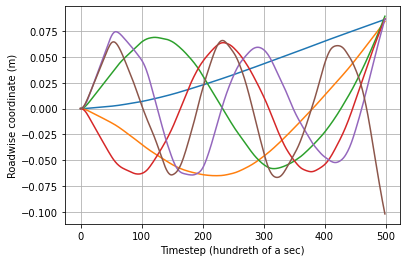

In [34]:
import sklearn
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA

%matplotlib inline
fdgry = skfda.FDataGrid(y_trajs, np.arange(y_trajs.shape[1]))
fpca_y = FPCA(n_components=6)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
# plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

(0.0, 499.0, 0.0, 499.0)

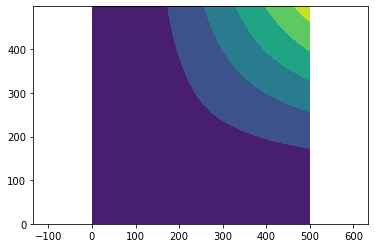

In [35]:
y_cov = fdgry.cov().data_matrix[0,:,:,0]
plt.contourf(y_cov)
plt.axis('equal')

In [36]:
import pickle
with open('fpca_basis_1.pkl', 'rb') as f:
    basis1 = pickle.load(f)
basis2 = fpca_y.components_.data_matrix.reshape(6,500)

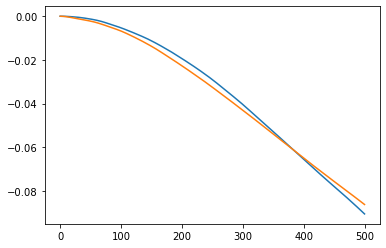

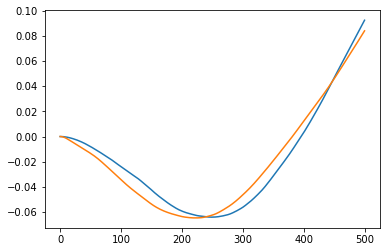

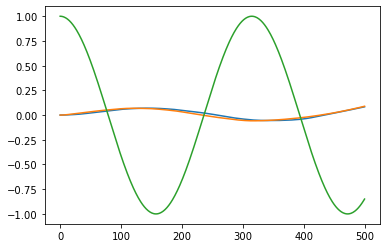

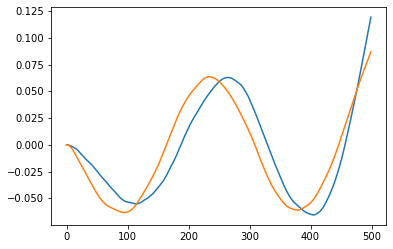

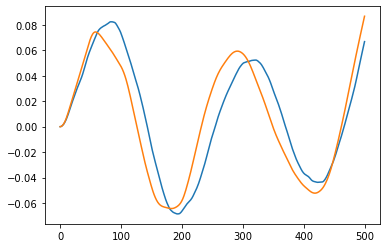

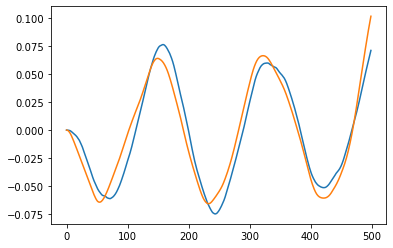

In [43]:

for component_id in range(6):
    ax = plt.subplot() 
    ax.plot(basis1[component_id, :])
    if component_id in [0, 5]:
        ax.plot(-basis2[component_id, :])
    else:
        ax.plot(basis2[component_id, :])
    if component_id in [2]:
        ax.plot(np.cos(np.arange(500) * 0.02))
    plt.show()